# Time Series Analysis Exercise

## Imports

In [1]:
import wrangle as w
import model as m
import numpy as np
import pandas as pd

#viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
#for presentation purposes
import warnings
warnings.filterwarnings("ignore")

#working with dates
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

#evaluated performance using rmse
import statsmodels.api as sm

#holts linear trend model
from statsmodels.tsa.api import Holt

## Acquire

In [2]:
#acquire data from wrangle
df = w.get_satx()

In [3]:
#take a peek at the first few rows of data
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
6618616,1820-01-01,7.169,3.676,San Antonio,United States,29.74N,97.85W
6618617,1820-02-01,11.448,2.964,San Antonio,United States,29.74N,97.85W
6618618,1820-03-01,15.003,2.413,San Antonio,United States,29.74N,97.85W
6618619,1820-04-01,21.022,2.136,San Antonio,United States,29.74N,97.85W
6618620,1820-05-01,23.938,1.923,San Antonio,United States,29.74N,97.85W


In [4]:
#check out the shape of the data
df.shape


(2325, 7)

In [5]:
#summary of columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 6618616 to 6620940
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2325 non-null   object 
 1   AverageTemperature             2316 non-null   float64
 2   AverageTemperatureUncertainty  2316 non-null   float64
 3   City                           2325 non-null   object 
 4   Country                        2325 non-null   object 
 5   Latitude                       2325 non-null   object 
 6   Longitude                      2325 non-null   object 
dtypes: float64(2), object(5)
memory usage: 145.3+ KB


In [6]:
#summary statistics
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,2316.000000,2316.000000
mean,19.980095,0.812963
std,6.870505,0.810973
min,4.023000,0.061000
25%,13.748250,0.262000
50%,20.305500,0.399000
75%,26.686000,1.240000
max,32.166000,5.063000


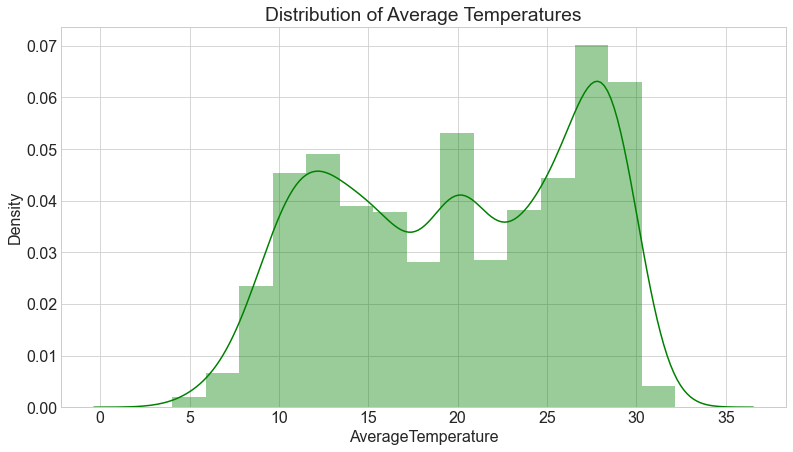

In [7]:
#distribution of target variable
avg_temperature=df['AverageTemperature'].dropna()
sns.distplot(avg_temperature, color = 'green') 
plt.title('Distribution of Average Temperatures')
plt.show()

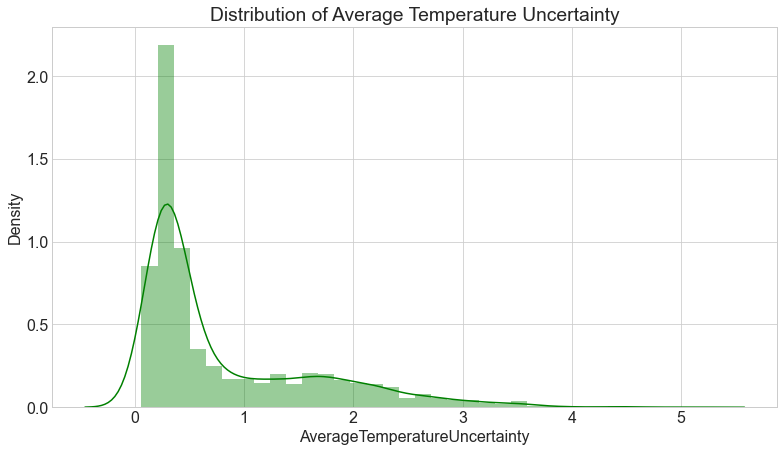

In [8]:
#distribution of average temperature uncertainty
avg_temperature_uncertainty=df['AverageTemperatureUncertainty'].dropna()
sns.distplot(avg_temperature_uncertainty, color = 'green') 
plt.title('Distribution of Average Temperature Uncertainty')
plt.show()

## Prepare

#### Prepare summary:
The following steps are used in this function to clean and prepare the dataframe:
- Reassign the dt object type column to be a datetime type
- Sort rows by the date and then set the index as that date
- make new columns for month and weekday
- rename column names
- fill nulls
- convert celsius to fareheit 

In [9]:
#clean and prep data
df = w.wrangle_satx()

In [10]:
#ensure all functions worked as described
df.head()

,avg_temp,avg_temp_uncertainty,year,month,weekday,season,decade
dt,,,,,,,
1820-01-01,44.9042,3.676,1820,1,Saturday,winter,1820s
1820-02-01,52.6064,2.964,1820,2,Tuesday,winter,1820s
1820-03-01,59.0054,2.413,1820,3,Wednesday,spring,1820s
1820-04-01,69.8396,2.136,1820,4,Saturday,spring,1820s
1820-05-01,75.0884,1.923,1820,5,Monday,spring,1820s


### Split
1. We will use the training proportion method to split.
2. Identify the total length of the dataframe and multiply by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
4. Return train and test dataframes.

In [11]:
# set train size to be 50% of total 
train_size = int(len(df) * .5)
train_size

1162

In [12]:

# set validate size to be 30% of total 
validate_size = int(len(df) * .3)
validate_size

697

In [13]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

466

In [14]:
# validate will go from 1162 to 1858
validate_end_index = train_size + validate_size
validate_end_index

1859

In [15]:
#Use the values above to split our data into three dataframes:
# train, validate, and test
# train will go from 0 to 1162
train = df[: train_size]
# validate will go from 1162 to 1858
validate = df[train_size:validate_end_index]
# test will include 1859 to the end
test = df[validate_end_index:]

In [16]:
#verify the splits
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


Text(0.5, 1.0, 'Visualization of Train, Valildate, and Test')

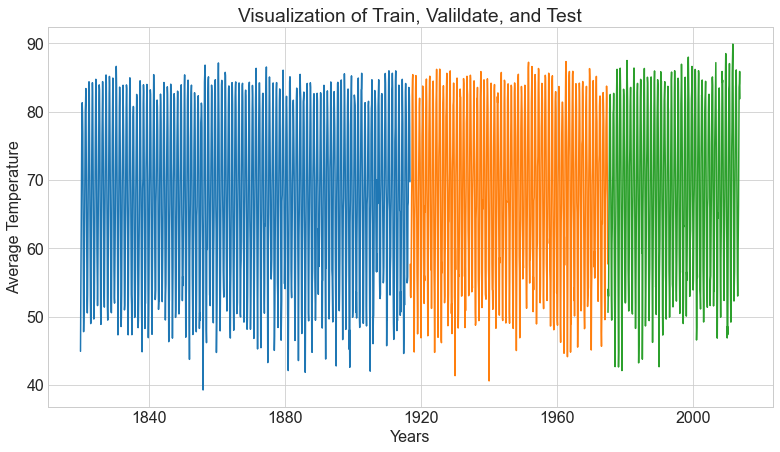

In [17]:
#Visualize the splits
plt.plot(train.index, train.avg_temp)
plt.plot(validate.index, validate.avg_temp)
plt.plot(test.index, test.avg_temp)
plt.xlabel('Years')
plt.ylabel('Average Temperature')
plt.title('Visualization of Train, Valildate, and Test')


## Explore

In [18]:
#store our target in a variable named y for ease of access
y = train.avg_temp
y.head()

dt
1820-01-01    44.9042
1820-02-01    52.6064
1820-03-01    59.0054
1820-04-01    69.8396
1820-05-01    75.0884
Name: avg_temp, dtype: float64

[Text(0.5, 1.0, 'San Antonio Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temperature (F)')]

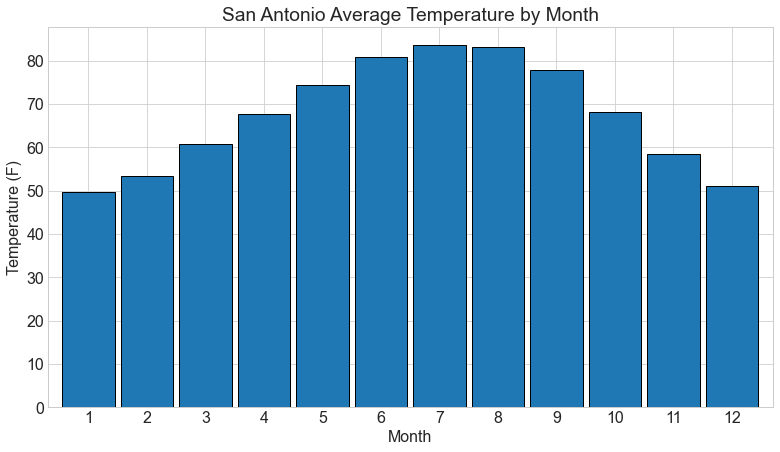

In [19]:
#Average temperature by month

ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='San Antonio Average Temperature by Month', xlabel='Month', ylabel='Temperature (F)')

Text(0.5, 1.0, 'San Antonio Average Temperature by Month')

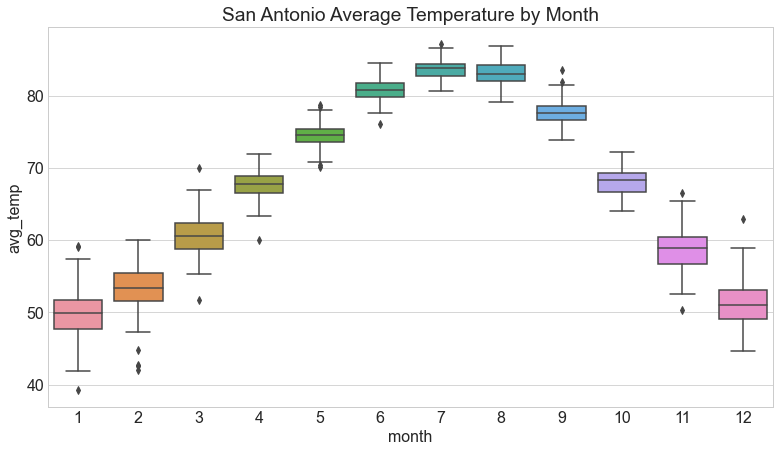

In [20]:
#boxplot of avg monthly temps
sns.boxplot(data = train, x = 'month', y = 'avg_temp')
plt.title('San Antonio Average Temperature by Month')

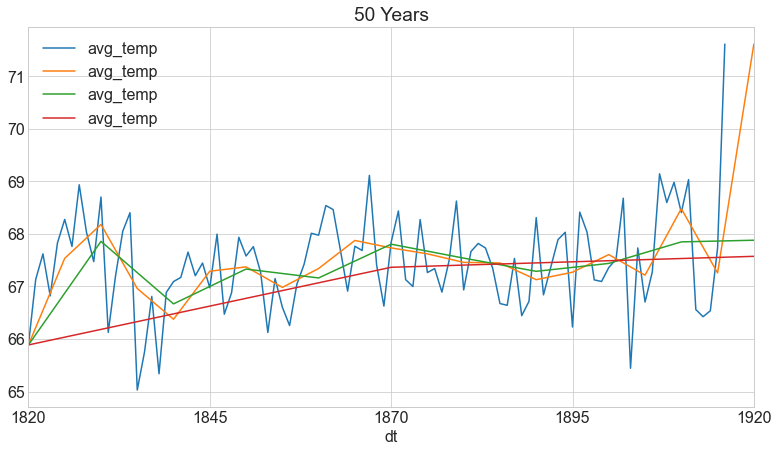

In [21]:
#avg temp over time
y.resample('1Y').mean().plot(title='1 Year')
y.resample('5Y').mean().plot(title='5 Years')
y.resample('10Y').mean().plot(title='10 Years')
y.resample('50Y').mean().plot(title='50 Years')
plt.legend()

Text(0.5, 1.0, 'Min, Mean, and Max Avg Temperatures Every 6 Months')

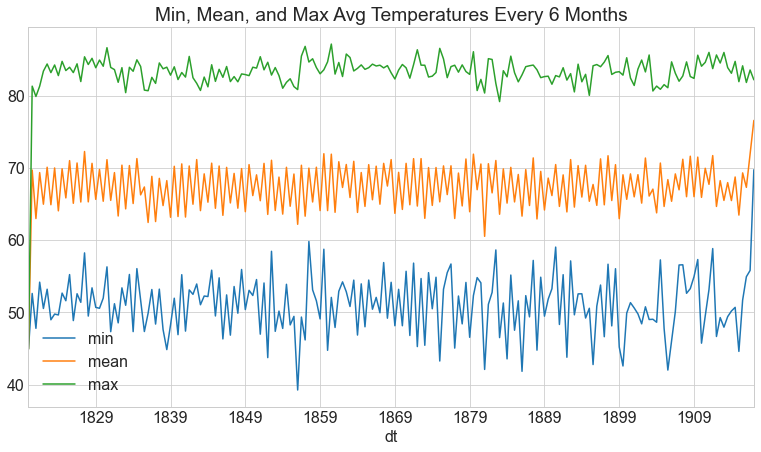

In [22]:
#six month resample
y.resample('6M').agg(['min', 'mean', 'max']).plot()
plt.title('Min, Mean, and Max Avg Temperatures Every 6 Months')

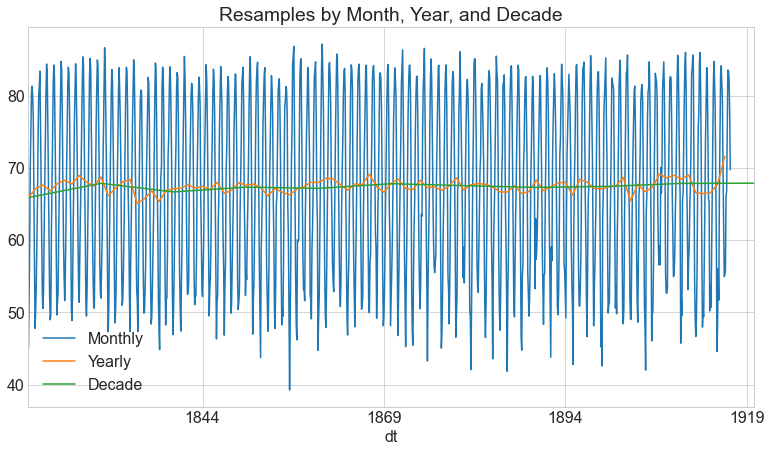

In [23]:
y.resample('M').mean().plot(label='Monthly')
y.resample('Y').mean().plot(label='Yearly')
y.resample('10Y').mean().plot(label='Decade')
plt.title('Resamples by Month, Year, and Decade')
plt.legend()

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='dt'>

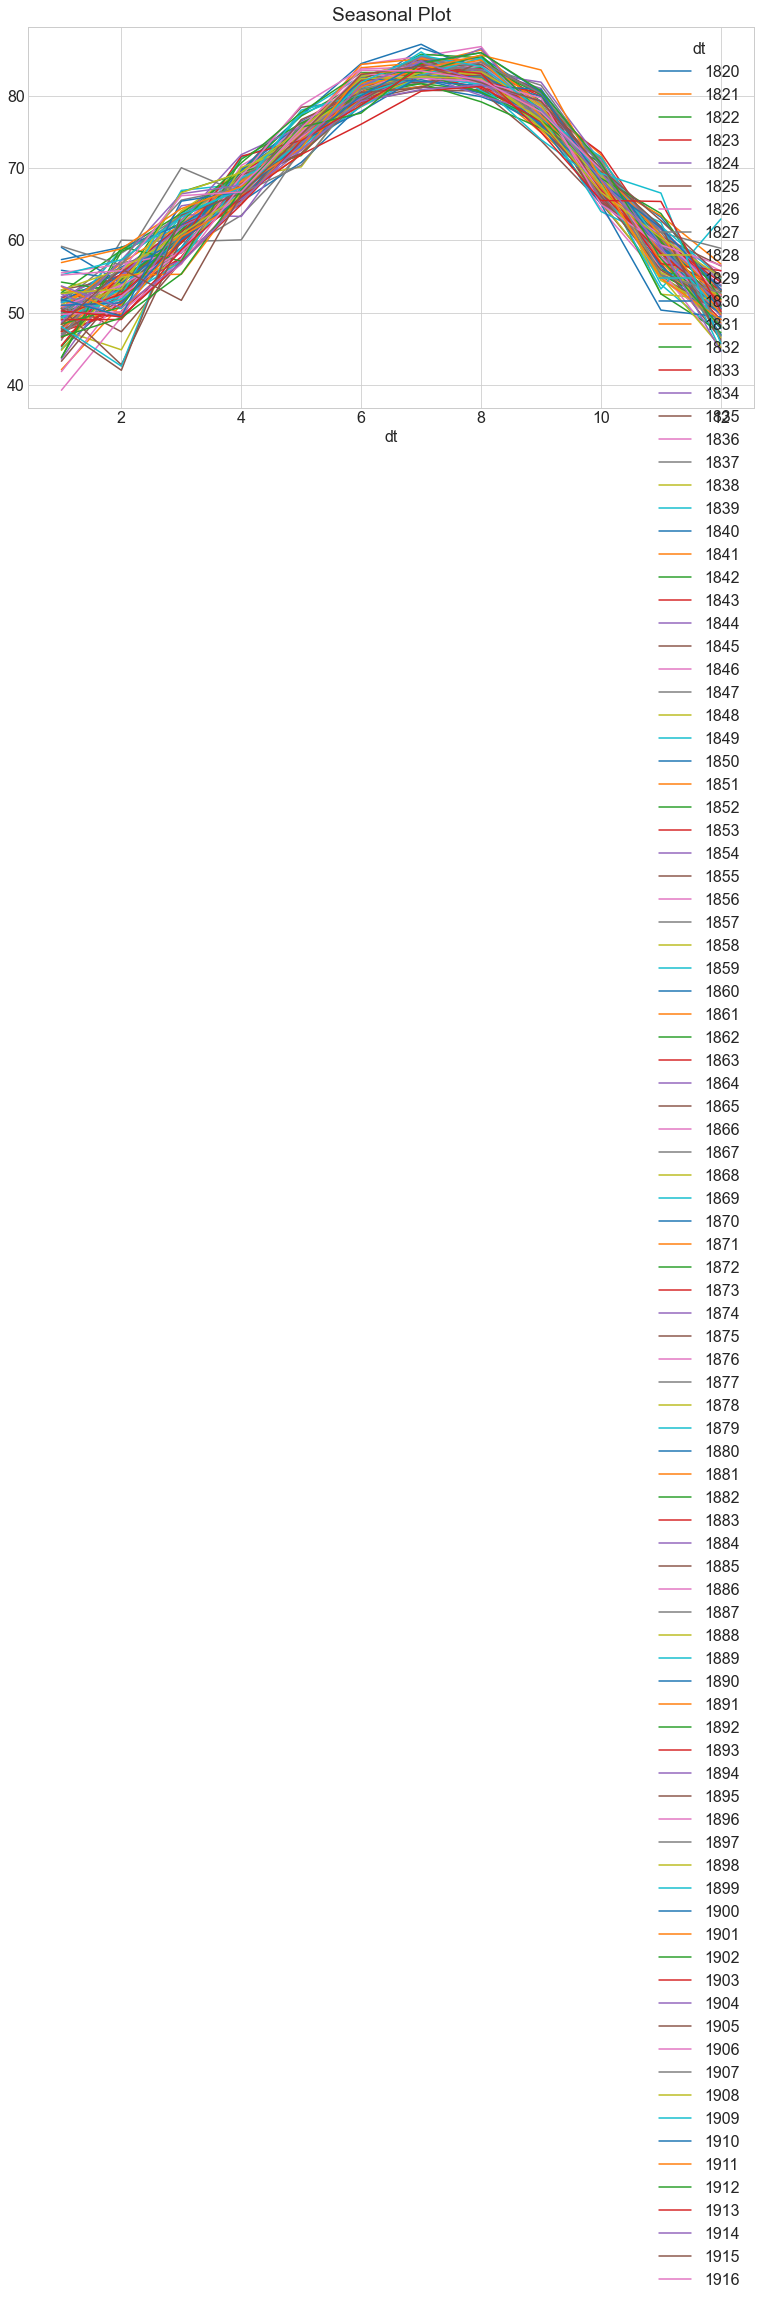

In [24]:
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

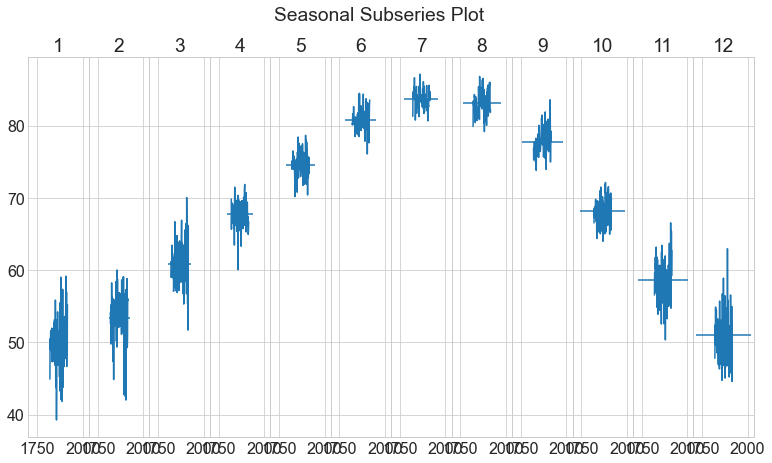

In [25]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

<AxesSubplot:title={'center':'Average month-to-month change in temperature'}, xlabel='dt'>

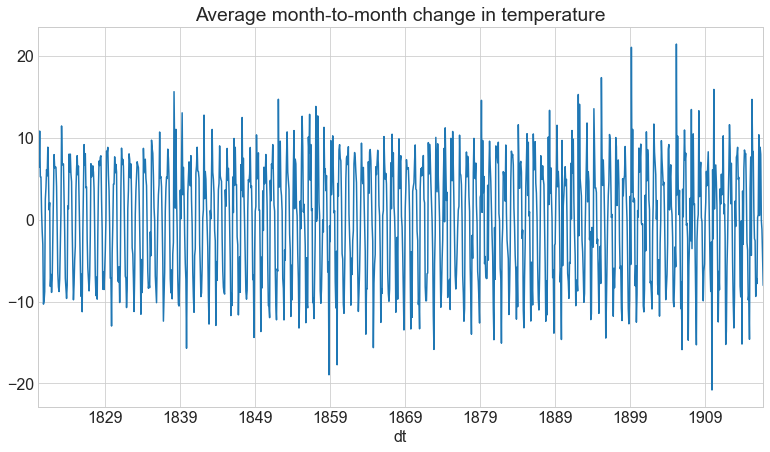

In [26]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in temperature')

<AxesSubplot:title={'center':'Average year-to-year change in temperature'}, xlabel='dt'>

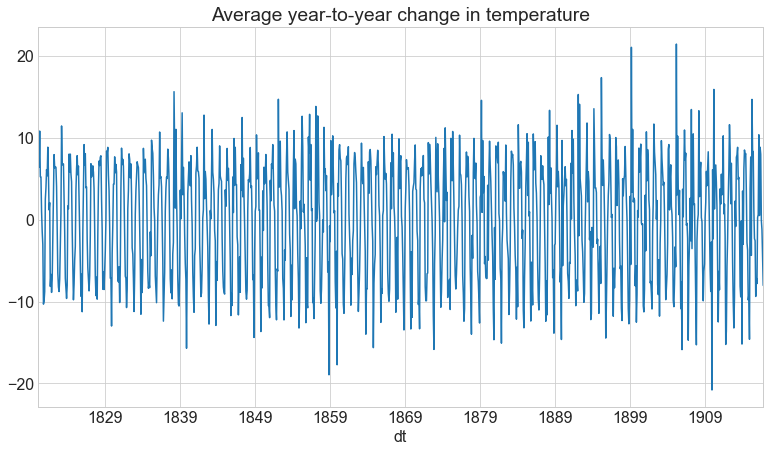

In [27]:
y.resample('M').mean().diff().plot(title='Average year-to-year change in temperature')

In [28]:
spring_temps = df[(df.season == 'spring')]
summer_temps = df[(df.season == 'summer')]
fall_temps = df[(df.season == 'fall')]
winter_temps = df[(df.season == 'winter')]


Text(0.5, 1.0, 'Spring Average Temps Through The Years')

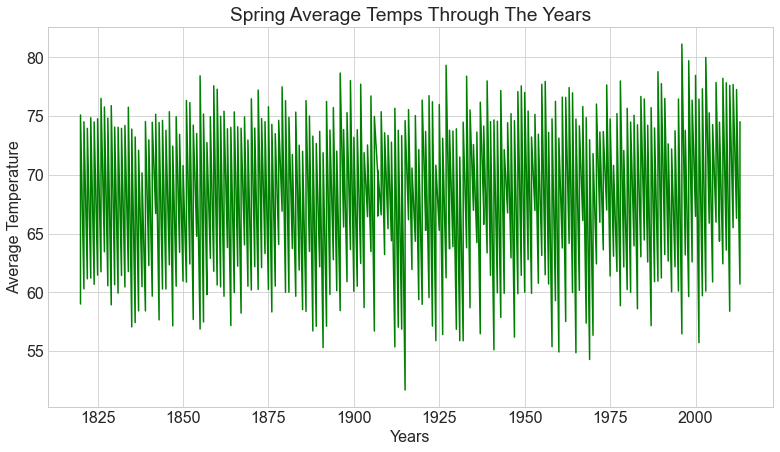

In [51]:
#Average temperature each season
#spring
plt.plot(spring_temps.year, spring_temps.avg_temp, label='Spring average temperature', color='green')
plt.xlabel('Years')
plt.ylabel('Average Temperature')
plt.title('Spring Average Temps Through The Years')

Text(0.5, 1.0, 'Summer Average Temps Through The Years')

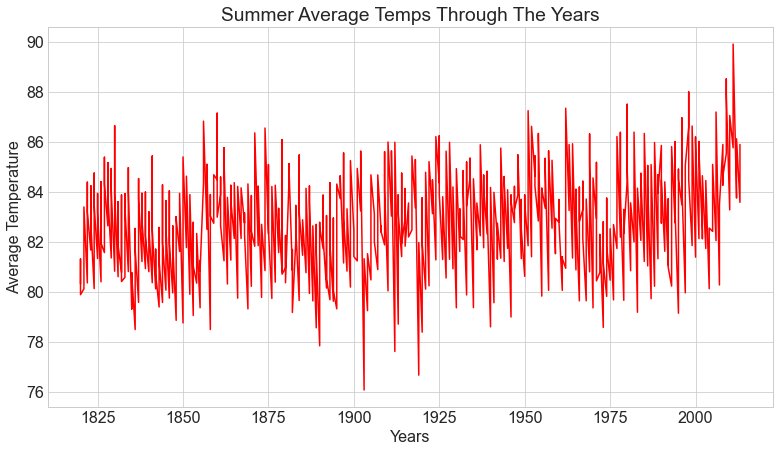

In [48]:
#summer
plt.plot(summer_temps.year, summer_temps.avg_temp, label='Summer average temperature', color='red')
plt.xlabel('Years')
plt.ylabel('Average Temperature')
plt.title('Summer Average Temps Through The Years')


Text(0.5, 1.0, 'Fall Average Temps Through The Years')

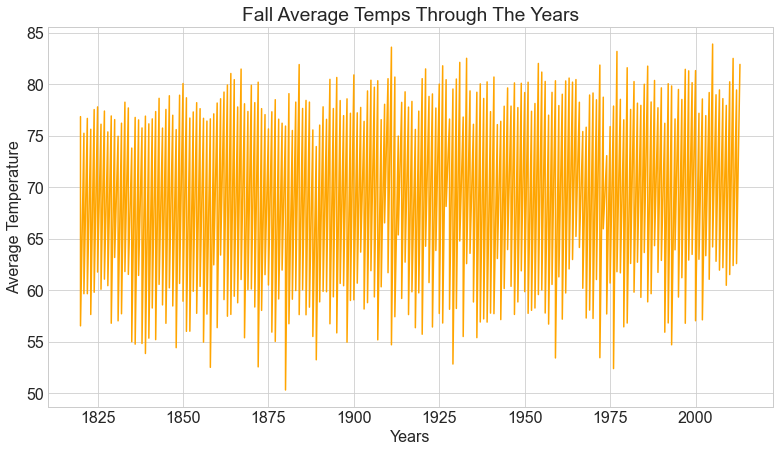

In [49]:
#fall
plt.plot(fall_temps.year, fall_temps.avg_temp, label='Fall average temperature', color='orange')
plt.xlabel('Years')
plt.ylabel('Average Temperature')
plt.title('Fall Average Temps Through The Years')

Text(0.5, 1.0, 'Winter Average Temps Through The Years')

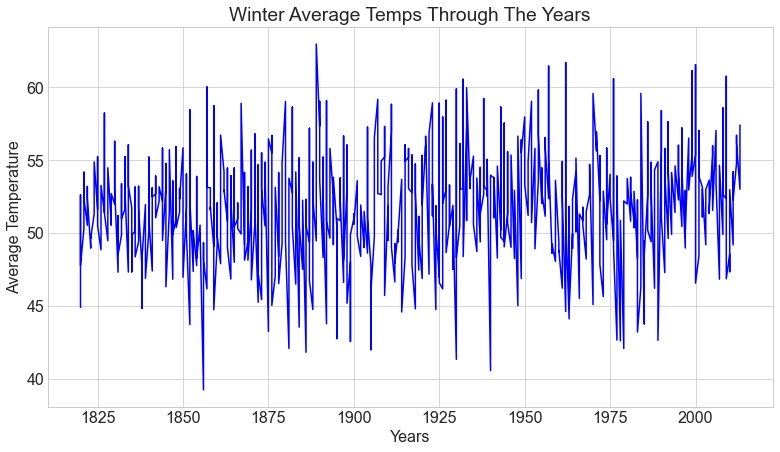

In [50]:
#winter
plt.plot(winter_temps.year, winter_temps.avg_temp, label='Winter average temperature', color='blue')
plt.xlabel('Years')
plt.ylabel('Average Temperature')
plt.title('Winter Average Temps Through The Years')

## Model

In [33]:
#modeling functions
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
#append eval df variable
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


def make_predictions():
    yhat_df = pd.DataFrame({'avgtemp': [avgtemp], 
                            'avgtempuncertainty': [avgtempuncertainty]}, 
                           index = validate.index)
    return yhat_df

#### Last observed value:


In [34]:
#Make predictions:  using the last observed value
avgtemp = round(train['avg_temp'][-1:][0], 2)
avgtemp


69.74

In [35]:
# take the last item of average temp uncertainty and assign to variable
avgtempuncertainty = train['avg_temp_uncertainty'][-1:][0]
avgtempuncertainty

0.301

In [36]:
#dataframe of predicted values
yhat_df = pd.DataFrame({'avg_temp': [avgtemp], 
                        'avg_temp_uncertainty': [avgtempuncertainty]}, 
                      index = validate.index)

yhat_df.head()

,avg_temp,avg_temp_uncertainty
dt,,
1916-11-01,69.74,0.301
1916-12-01,69.74,0.301
1917-01-01,69.74,0.301
1917-02-01,69.74,0.301
1917-03-01,69.74,0.301


In [37]:
#summary statistics

yhat_df.describe()

,avg_temp,avg_temp_uncertainty
count,6.970000e+02,6.970000e+02
mean,6.974000e+01,3.010000e-01
std,1.848738e-13,3.999673e-15
min,6.974000e+01,3.010000e-01
25%,6.974000e+01,3.010000e-01
50%,6.974000e+01,3.010000e-01
75%,6.974000e+01,3.010000e-01
max,6.974000e+01,3.010000e-01


avg_temp -- RMSE: 12


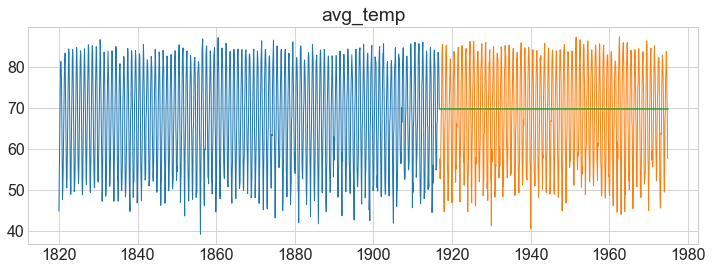

In [38]:
#Plot Actual vs. Predicted Values
#avg_temp
plot_and_eval('avg_temp')

avg_temp_uncertainty -- RMSE: 0


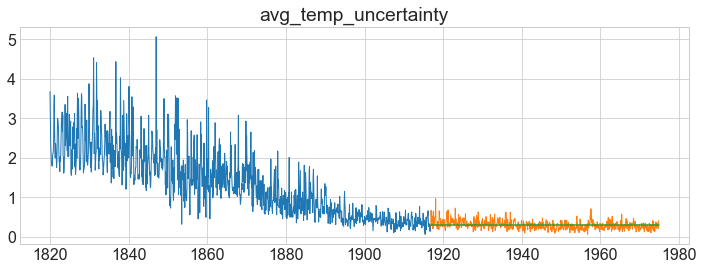

In [39]:
#Plot Actual vs. Predicted Values
#avg_temp_uncertainty
plot_and_eval('avg_temp_uncertainty')

In [40]:
#Evaluate using MSE and RMSE
#Add evaluation metrics to eval df
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [41]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'avg_temp')

In [42]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,12.0


In [43]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'avg_temp_uncertainty')

In [44]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,12.0
1,last_observed_value,avg_temp_uncertainty,0.0


#### Simple Average

In [45]:
#compute simple average for avg temp
avgtemp = round(train['avg_temp'].mean(), 2)

#compute simple average for avg temp uncertainty
avgtempuncertainty = round(train['avg_temp_uncertainty'].mean(), 2)

print(avgtemp, ',', avgtempuncertainty)

67.45 , 1.36


In [46]:
#Apply predictions to our observations
yhat_df = make_predictions()
yhat_df.head()

,avgtemp,avgtempuncertainty
dt,,
1916-11-01,67.45,1.36
1916-12-01,67.45,1.36
1917-01-01,67.45,1.36
1917-02-01,67.45,1.36
1917-03-01,67.45,1.36


In [47]:
#Plot Actual vs. Predicted Values
#avg_temp


## Conclusion